# 1/3 부분쯤 프로젝트 시작입니당 !

## keras-ocr 사용해보기

In [1]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [3]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

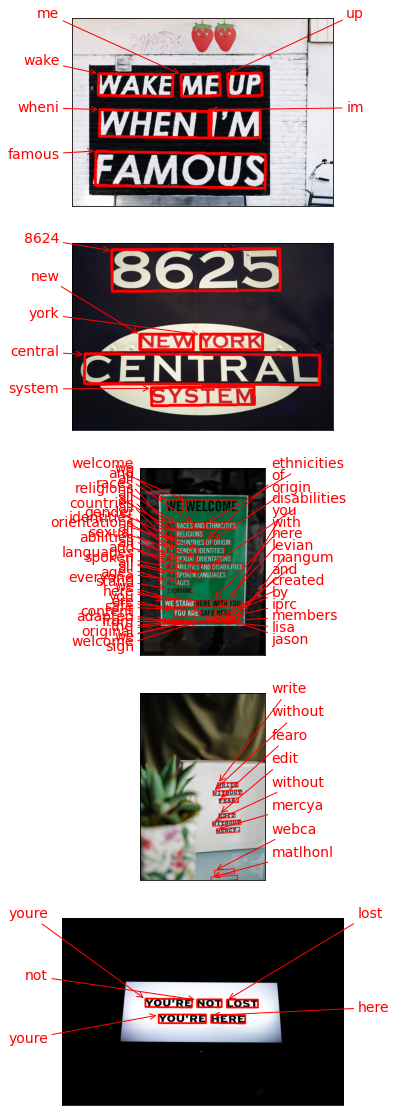

In [4]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## 테서랙트 써보기

### 1. 테서랙트 설치하기
아래 명령어로 설치할 수 있다.

 - `$` sudo apt install tesseract-ocr  <br/>
 - `$` sudo apt install libtesseract-dev

### 2. 테서랙트 파이썬 wrapper 설치하기
Pytesseract는 OS에 설치된 테서랙트를 파이썬에서 쉽게 사용할 수 있도록 해주는 래퍼 라이브러리(wrapper library)이다.

아래 명령어로 설치할 수 있다.

- `$` pip list | grep pytesseract

### 3. 테서랙트로 문자 검출하고 이미지 자르기 (detection)
1. 테서랙트를 사용하면 한 번에 이미지 내의 문자 검출과 인식을 할 수 있다.
2. OCR이 이뤄지는 전체 과정을 직접 거쳐보기 위해 검출을 먼저 해본다.

In [5]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/ocrimage1.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png


#### 위의 lang='kor'로 변경하게 되면 에러가 발생하는데 언어팩을 설치하지 않아서이다. 

결론은 `테서랙트의 언어팩을 설치해줘야 정상동작된다.`

- `$` sudo apt install tesseract-ocr-kor

1. 위에서 구현한 `crop_word_regions()` 함수는 선택한 테스트 이미지를 받아서, 문자 검출을 진행한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수이다.
2. 기본적으로 `pytesseract.image_to_data()` 를 사용한다.
3. 파이썬을 편하게 사용하기 위해` pytesseract` 의 `Output` 을 사용해서 결괏값을 딕셔너리 형식으로 설정해 주게 되고 이렇게 인식된 결과는 바운딩 박스의 left, top, width, height 정보를 가진다.
4. 바운딩 박스를 사용해 이미지의 문자 영역을 파이썬 `PIL` or `opencv`라이브러리를 사용해 잘라(crop)서 `cropped_image_path_list`에 담아 리턴했다.

### 4. 테서랙트로 잘린 이미지에서 단어 인식하기

검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결괏값으로 나오는 `image_to_string()`를 사용하게된다.

In [6]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

0/“/

2

^/-거/

2002 7


Done


## 프로젝트 : 다양한 OCR 모델 비교하기


In [7]:
# 주요 라이브러리 버전 확인하기
import keras_ocr
import pytesseract

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


### 1. 검증용 데이터셋 준비

In [9]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [15]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_file = os.getenv('HOME')+ '/aiffel/ocr_python/test_image'
image_list = os.listdir(image_file)

image_list = [os.path.join(image_file, image_list[file]) for file in range(len(image_list))]
image_list

['/aiffel/aiffel/ocr_python/test_image/test4.jpg',
 '/aiffel/aiffel/ocr_python/test_image/test3.jpg',
 '/aiffel/aiffel/ocr_python/test_image/test2.jpg',
 '/aiffel/aiffel/ocr_python/test_image/test6.jpg',
 '/aiffel/aiffel/ocr_python/test_image/test1.jpg',
 '/aiffel/aiffel/ocr_python/test_image/test5.jpg',
 '/aiffel/aiffel/ocr_python/test_image/test7.jpg']

### 2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택사항)

### Keras-ocr

In [16]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [17]:
images = [ keras_ocr.tools.read(image) for image in image_list]
prediction_groups = [pipeline.recognize([image]) for image in image_list]

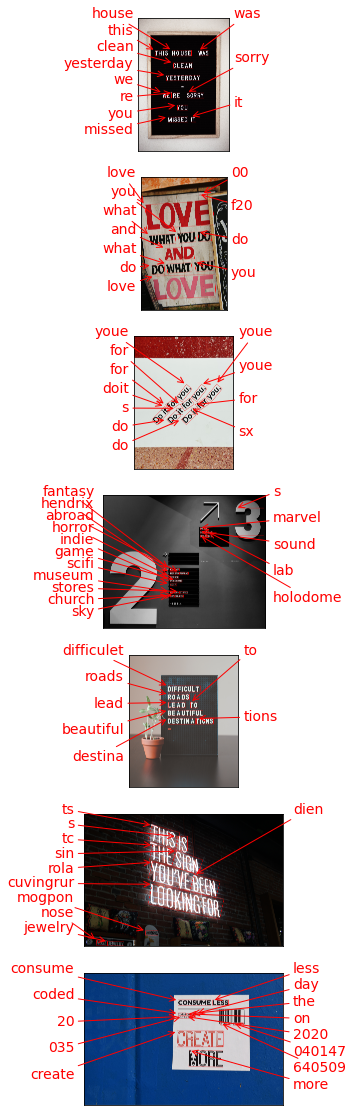

In [18]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### Tesseract

In [20]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path, output_path):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python/test_image'
img_file_path = work_dir + '/test1.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/test_image/0000.png
/aiffel/aiffel/ocr_python/test_image/0001.png
/aiffel/aiffel/ocr_python/test_image/0002.png
/aiffel/aiffel/ocr_python/test_image/0003.png
/aiffel/aiffel/ocr_python/test_image/0004.png
/aiffel/aiffel/ocr_python/test_image/0005.png
/aiffel/aiffel/ocr_python/test_image/0006.png
/aiffel/aiffel/ocr_python/test_image/0007.png
/aiffel/aiffel/ocr_python/test_image/0008.png


In [21]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)


| is

ROADS

LEAD TO

BE AUTIFUL

DESTIN

A TIONS

BS


Done


In [22]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/test_image'
img_file_path = work_dir + '/test2.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/test_image/0000.png
/aiffel/aiffel/ocr_python/test_image/0001.png


In [23]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)



Done


In [25]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/test_image'
img_file_path = work_dir + '/test4.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/test_image/0000.png
/aiffel/aiffel/ocr_python/test_image/0001.png
/aiffel/aiffel/ocr_python/test_image/0002.png
/aiffel/aiffel/ocr_python/test_image/0003.png
/aiffel/aiffel/ocr_python/test_image/0004.png


In [26]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

Ina

HOUSE

oe

YESTERDAY

4

Done


In [28]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/test_image'
img_file_path = work_dir + '/test6.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/test_image/0000.png
/aiffel/aiffel/ocr_python/test_image/0001.png
/aiffel/aiffel/ocr_python/test_image/0002.png
/aiffel/aiffel/ocr_python/test_image/0003.png
/aiffel/aiffel/ocr_python/test_image/0004.png
/aiffel/aiffel/ocr_python/test_image/0005.png
/aiffel/aiffel/ocr_python/test_image/0006.png
/aiffel/aiffel/ocr_python/test_image/0007.png
/aiffel/aiffel/ocr_python/test_image/0008.png
/aiffel/aiffel/ocr_python/test_image/0009.png
/aiffel/aiffel/ocr_python/test_image/0010.png
/aiffel/aiffel/ocr_python/test_image/0011.png
/aiffel/aiffel/ocr_python/test_image/0012.png
/aiffel/aiffel/ocr_python/test_image/0013.png
/aiffel/aiffel/ocr_python/test_image/0014.png
/aiffel/aiffel/ocr_python/test_image/0015.png
/aiffel/aiffel/ocr_python/test_image/0016.png
/aiffel/aiffel/ocr_python/test_image/0017.png
/aiffel/aiffel/ocr_python/test_image/0018.png
/aiffel/aiffel/ocr_python/test_image/0019.png
/aiffel/aiffel/ocr_python/test_image/0020.png
/aiffel/aiffel/ocr_python/test_ima

In [29]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

a

2


ae


eee eee a

FANTASY

.

Srnec

HENDRIX

ABROAD

HORROR

|

remem

INDIE

GAME

A

MUSEUM

STORES

SK Y

iT]:

CH

5

ty

Done


### 3. 테스트 결과 정리

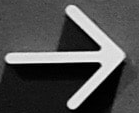

In [32]:
from PIL import Image
import matplotlib.pyplot as plt

img_file_path = work_dir + '/0000.png'
image = Image.open(img_file_path)
image.show()

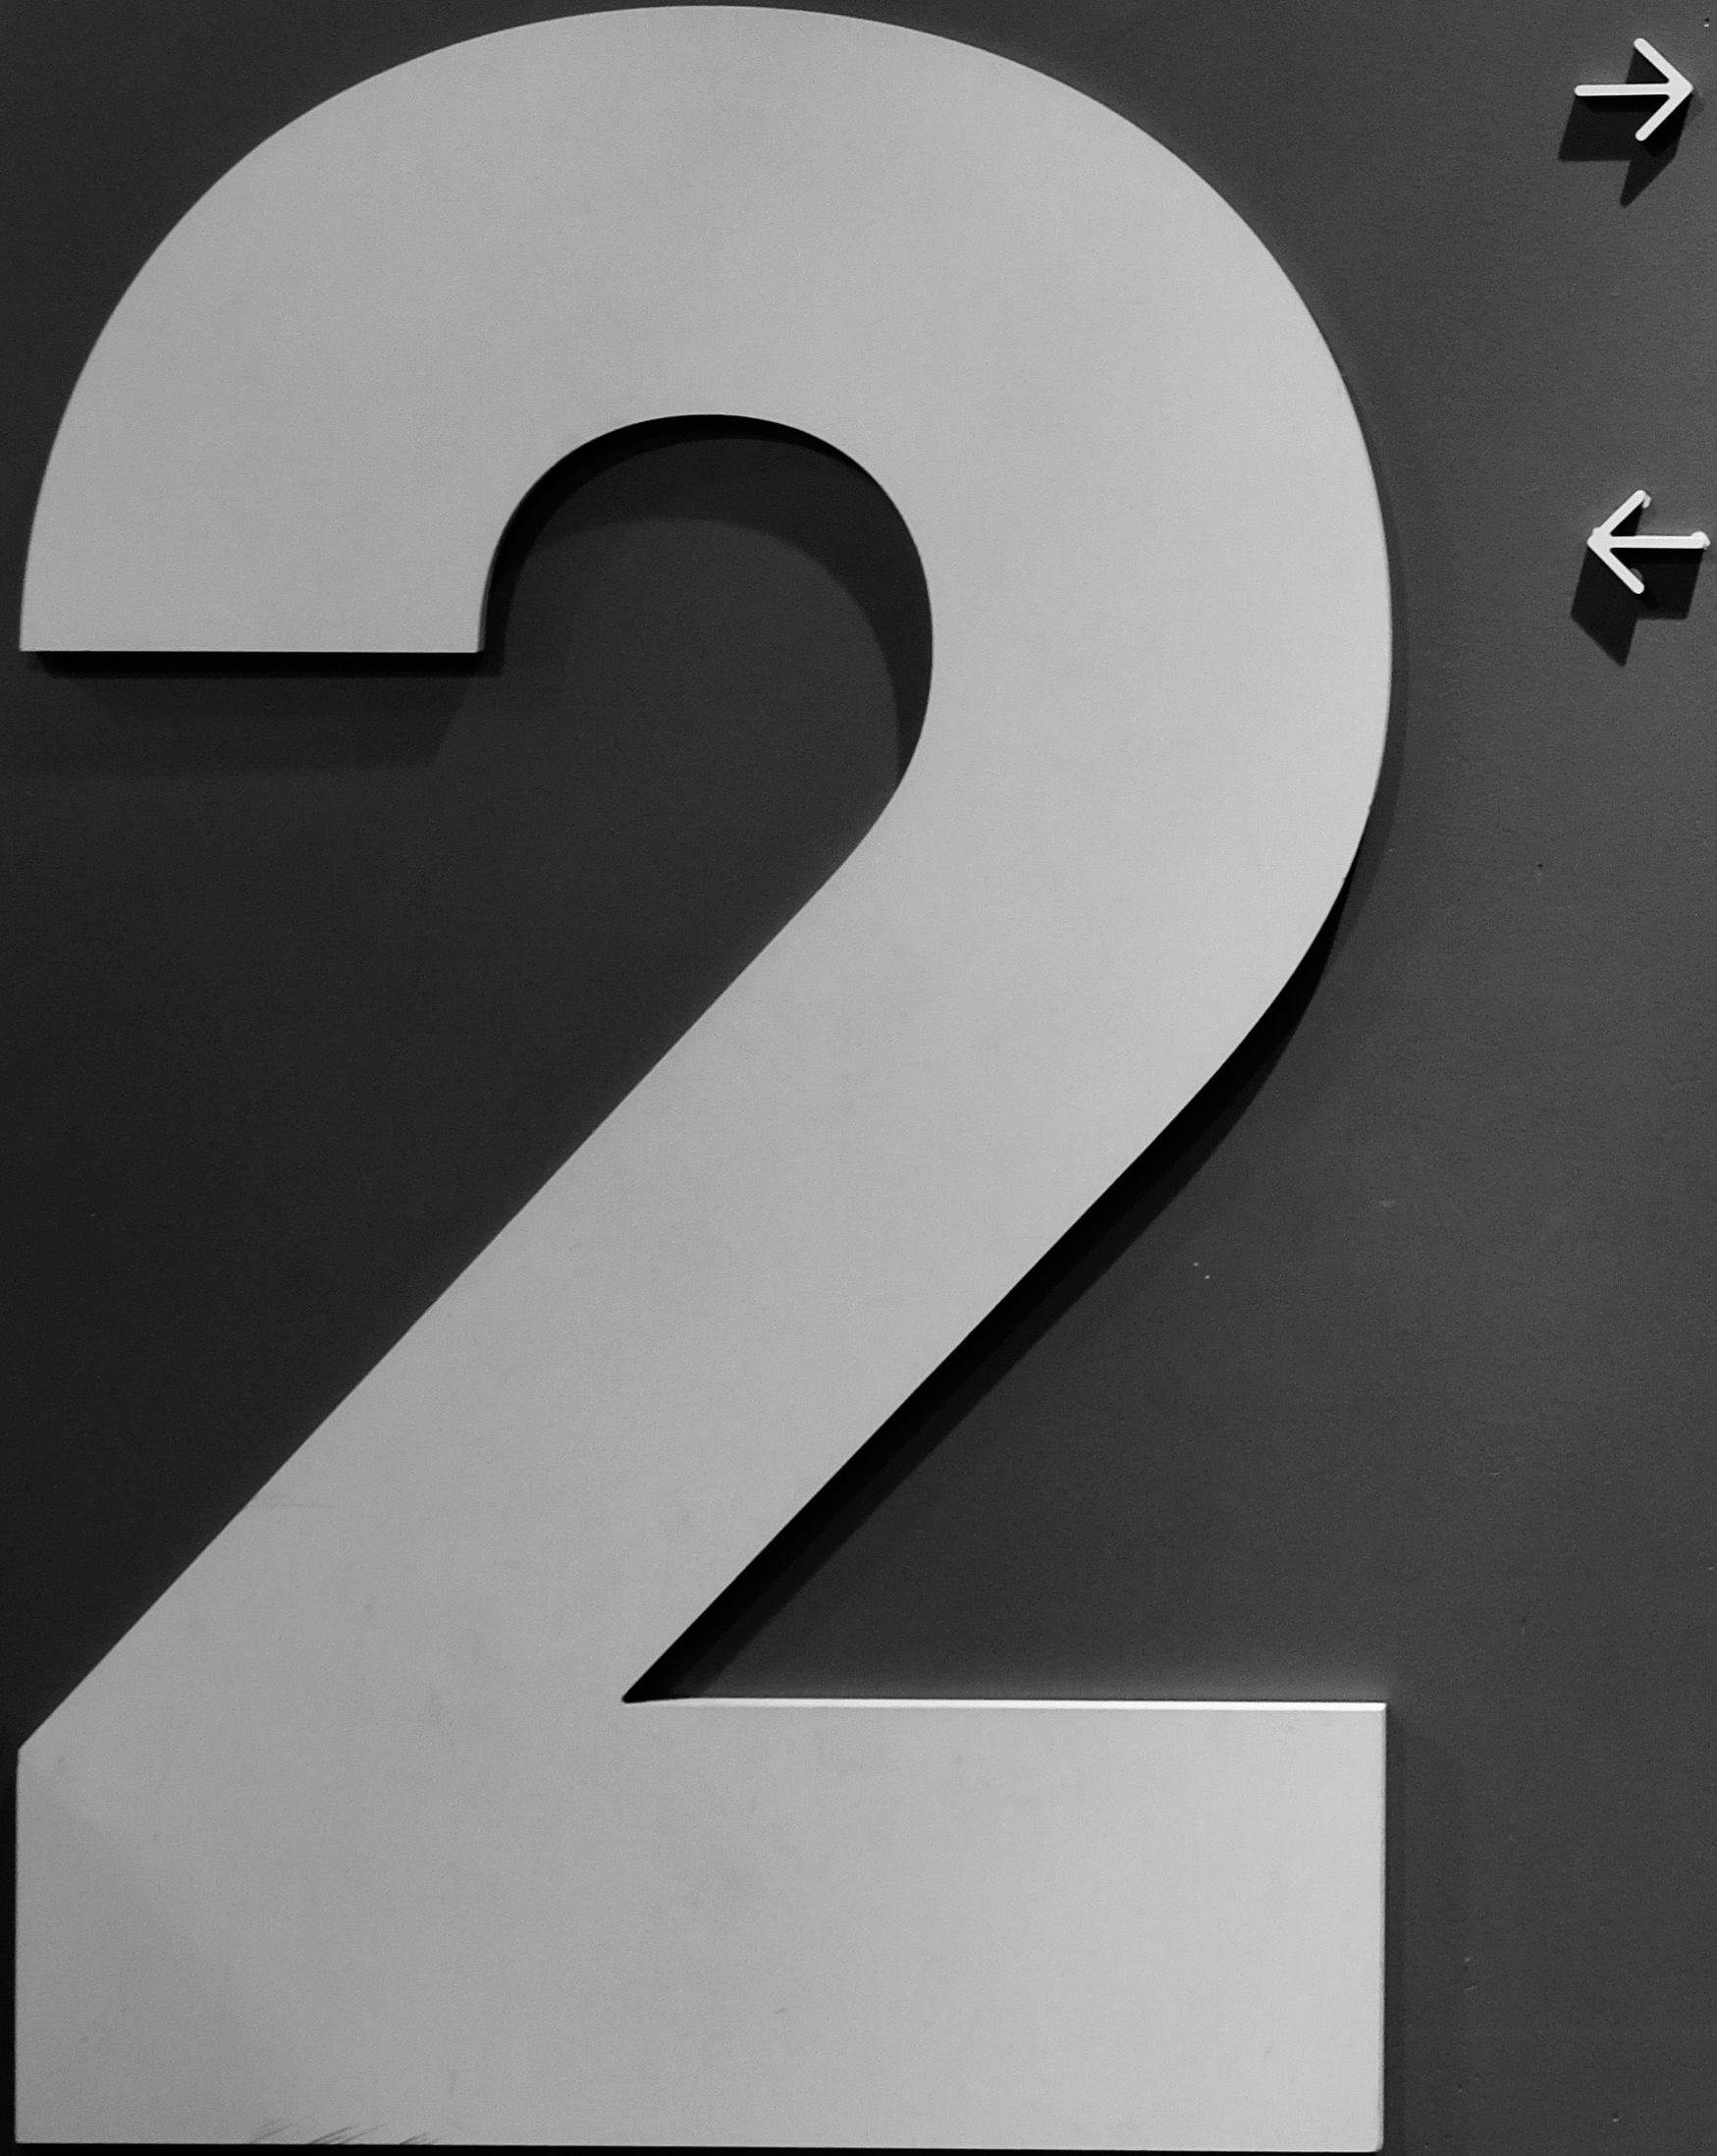

In [33]:
img_file_path = work_dir + '/0001.png'
image = Image.open(img_file_path)
image.show()

In [34]:
img_file_path = work_dir + '/0003.png'
image = Image.open(img_file_path)
image.show()

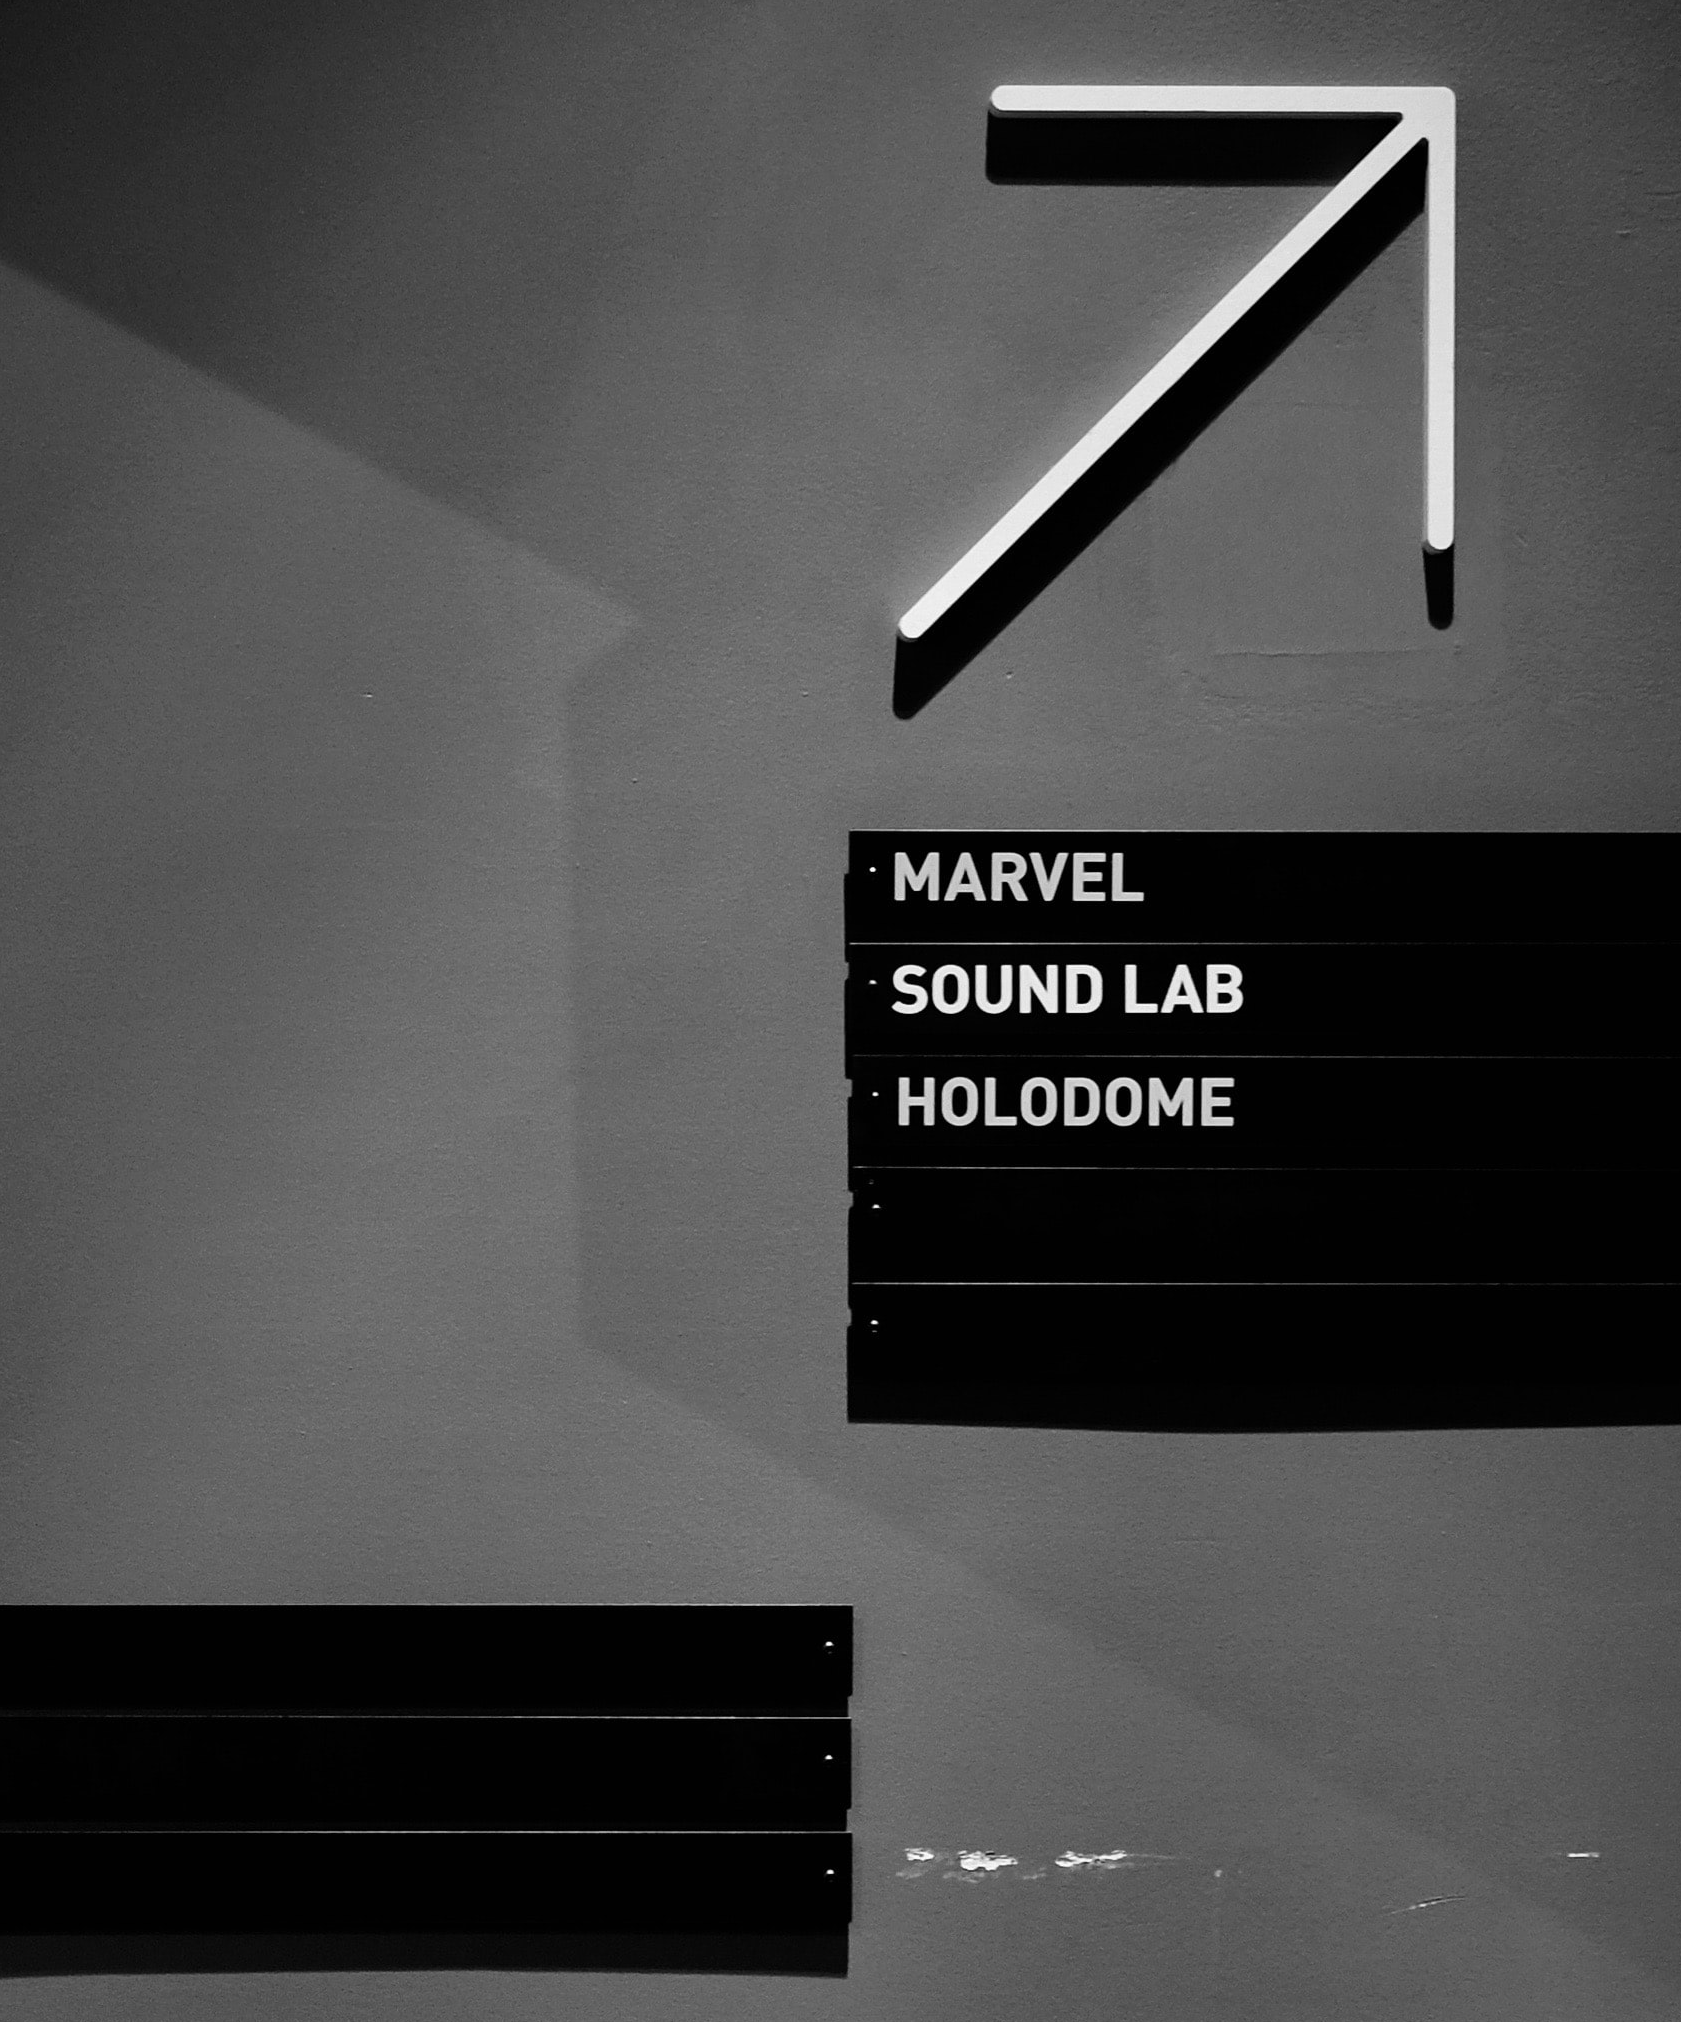

In [35]:
img_file_path = work_dir + '/0004.png'
image = Image.open(img_file_path)
image.show()

In [36]:
img_file_path = work_dir + '/0005.png'
image = Image.open(img_file_path)
image.show()

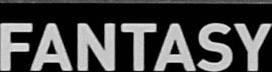

In [37]:
img_file_path = work_dir + '/0006.png'
image = Image.open(img_file_path)
image.show()

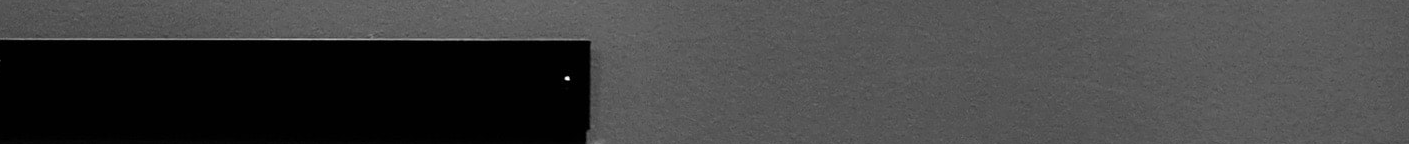

In [38]:
img_file_path = work_dir + '/0007.png'
image = Image.open(img_file_path)
image.show()

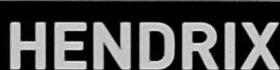

In [40]:
img_file_path = work_dir + '/0009.png'
image = Image.open(img_file_path)
image.show()

### 회고
이렇게 인터넷에 떠도는 이미지를 가지고 keras-ocr, tesseract를 한 결과를 보는 시간을 가졌다. 결과로 보자면 `keras-ocr`이 훌륭한 단어 추출을 해내는 것을 볼 수 있었다. tesseract는 단어를 잘 추출해내지 못하는 경향이 있었는데 문자 검출해낸 이미지를 확인해보니 문자 자체를 검출해내는 능력이 많이 부족해 보였다. 그리고 keras-ocr은 틀린 부분도 있었지만 그래도 높은 정확도로 문자를 검출해내고 단어를 나타내는 결과를 볼 수 있었다. 아마도 문자 검출해내는 능력 때문에 이런 결과가 나왔다고 생각한다.

그리고 모델을 좀 더 정확하게 만들어 낸다면 시각장애인 분들을 위해 좋은 보조기구를 만들어 낼 수 있을거라 생각한다. 안경과 유사한 기구를 쓰면 그 곳에 장착된 카메라를 통해 문자를 인식하고 추출해 읽어주는 그런 기계가 나온다면 몸이 불편하신 시각장애인 분들에게 큰 도움이 되리라 믿는다.

오늘도 공부를 통해 세상에 이로운 영향력을 뽐낼 수 있는 기술을 알게된 것 같아서 만족스럽고 앞으로 더욱 열심히 공부해야겠다 !!! 